# Distributed Networks Convex Optimization
ENSTA - SOD 314 course

This notebook is based on the works presented in : [Sca19] "Optimal Convergence Rates for Convex Distributed Optimization in Networks" by Kevin Scaman, Francis Bach et al.

To improve the readability of this documents, we will be detailling here the parameters nomenclature (it is not the same as the one in the paper, nor the report we made) :
- $m$ : the dimensionality of our variable ($\alpha \in \mathbb{R}^m$).
- $a$ : number of devices/agents.
- $n$ : number of data points.
- $R$ : ray of the ball in which we set our algorithms.
- $L_g$ : lipschitz constant of the global problem.
- $\beta_g$ : strong convexity coefficient of the global problem.
- $\zeta_g$ : smooth coefficient of the global problem.
- $L_i$ : lipschitz constant of the $i^{th}$ objective function.
- $\beta_g$ : strong convexity coefficient of the $i^{th}$ objective function.
- $\zeta_g$ : smooth coefficient of the $i^{th}$ objective function.
- $L_l = \sqrt{\frac{1}{n}\sum_i L_i^2}$.
- $\beta_l = \min_i \beta_i$.
- $\zeta_l = \max_i \zeta_i$.

And here are some usefull informations to walk through this notebook :
- Unless stated otherwise, we won't need to set ourselves on the specific $\mathcal{K}$ bounded convexe set because, computationally speaking we are always on a convex bounded set if we "freed" the values (In python, we are in a ball of radius $\approx 10^{308}$). Nonetheless, if you take a look at each algorithm you will see that we are setting ourselves in a ball of radius $R$ (which verify the setting).
    - For the DRS algorithm more specifically in the convex case, the radius of the ball has a direct impact on the method itself. Thus, we will need then to carefully take a look at it (Indeed, we need to project on $\mathcal{K}=\mathcal{B}(0_m,R)$).
- On the first part which is about distributed algorithm, we won't need specific information on the graph. In the paper they do their computation with an all sharing matrix $W = \frac{1}{a}\mathbf{1}_{a\times a}$ because they set themselves in centralized objective. But for general purpose here, we will allow general graph (doubly stochastic) matrices and show that even with a local neighborhood graph, we reach the theoretically expected results.
- Note that during the whole test we conduced here, we have given ourselves a non-smooth setting.

## Assumptions

In their paper, the authors divide their study into $4$ kinds of assumptions :
- Lipschitz continuous + convexe
- Lipschitz continuous + strongly convexe
- Smoothness + convexe
- Smoothness + strongly convexe

(If you want a definition of those, please refer to [Sca19] p 4.)

For each, they propose algorithm and their optimal convergence rate. Let us realize a small study on those algorithm.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
def Cov(x):
    m = len(x)
    Kmm = np.eye(m)
    for ii in range(m):
        for jj in range(ii+1,m):
            Kmm[ii,jj] = np.exp(-(x[ii]-x[jj])**2 )
            Kmm[jj,ii] = Kmm[ii,jj]

    return Kmm

def Cov2(x1,x2):
    m = len(x2)
    n = len(x1)
    Knm = np.zeros([n,m])
    for ii in range(n):
        for jj in range(m):
            Knm[ii, jj] = np.exp(-(x1[ii] - x2[jj]) ** 2 )
    return Knm

In [3]:
def solve(x,y, selection=True):
    n = len(x)

    # you can either select the points among the ones you have:
    if selection:
        sel = [i for i in range(n)]
        ind = np.random.choice(sel, int(np.sqrt(n)), replace=False)
        x2 = [x[i] for i in ind]

    # or take them uniformly distributed
    else:
        x2 = np.linspace(-1, 1, 10)
        ind = []

    M = Cov2(x, x2)
    A = (0.5**2)*Cov(x2) + M.T @ M
    b = M.T @ y

    # here the regularization parameter nu is 1.0
    A = A + 1.*np.eye(int(np.sqrt(n)))

    # it is good to compute the max/min eigenvalues of A for later, but only for small-size matrices
    if n<101:
        ei, EI =np.linalg.eig(A)
        vv = [min(ei), max(ei)]
        print('Min and max eigenvalues of A : ', print(vv))

    alpha = np.linalg.solve(A,b)

    return alpha, ind

def plot_me(x,y, alpha, ind, selection=True):

    plt.plot(x,y,'o')

    xo = np.linspace(-1,1,100)
    if selection:
        x2 = [x[i] for i in ind]
    else:
        x2 = np.linspace(-1, 1, 10)

    yo = Cov2(xo, x2) @ alpha
    plt.plot(xo, yo, '-')
    plt.xlabel(r'$x$ feature')
    plt.ylabel(r'$y$ label')
    plt.grid()

    plt.show()

/tmp/ipykernel_988/992319396.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  x,y = pickle.load(f)


[np.float64(1.0000000000200129), np.float64(414.2775914131273)]
Min and max eigenvalues of A :  None
Result summary -----------------
Optimal centralised alpha =  [-0.18821903  0.9666048   0.13884532  0.33416509 -0.54349972 -0.60800918
 -0.13319535  0.97340183 -0.0872398   0.25092808]


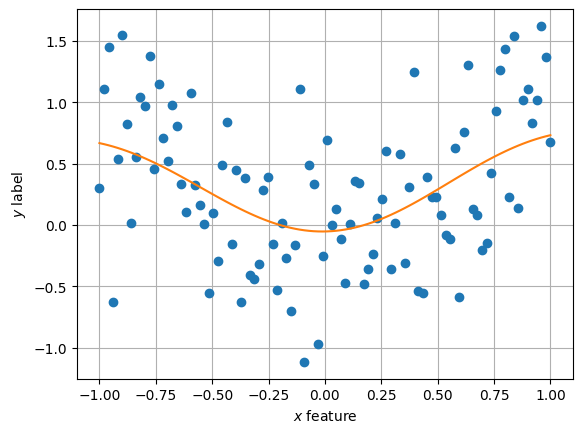

In [4]:
with open('first_database.pkl', 'rb') as f:
   x,y = pickle.load(f)


num_points = 100
alpha, ind = solve(x[:num_points],y[:num_points], selection=True)

print('Result summary -----------------')
print('Optimal centralised alpha = ', alpha)

plot_me(x[:num_points],y[:num_points], alpha, ind, selection=True)

In [5]:
def agent_partition(a, x, y, repartition = None):
    n = len(x)
    if repartition is None:
        repartition = [n//a]*a
    # make a repartition :
    x_parts = []
    y_parts = []
    # random repartition
    ind = np.random.permutation(n)
    for i in range(a):
        x_parts.append(x[ind[:repartition[i]]])
        y_parts.append(y[ind[:repartition[i]]])
        ind = ind[repartition[i]:]
    x_parts = np.array(x_parts)
    y_parts = np.array(y_parts)
    print(x_parts.shape)
    print(y_parts.shape)
    return x_parts, y_parts, ind

## Distributed Randomized Smoothing

Found : [Sca19] p 8.

Here, we set ourselves in the **non-smooth case**. A first impression would be that such a case is much harder (in SOD314 for example, we alway solved with smooth function) but this issue can be elegantly adressed by replacing our objective function $f$ with :
$$f^\gamma(\theta) = \mathbb{E}_{X\sim \mathcal{N}(0,I)}[f(\theta + \gamma X)]$$

In practical setting for the course SOD314 we try to solve :

$$\min_{\alpha \in \mathbb{R}^{m}} f(\alpha) := \frac{\sigma^2}{2} \alpha^\top K_{mm} \alpha + \frac{1}{2} \|y - K_{mm} \alpha\|_2^2 + \frac{\nu}{2} \|\alpha\|_2^2 $$

Which is a smooth problem (even strongly convex with carefully crafted matrix and parameters). Thus, we are going to change a bit the problem so that it is no longer smooth but we could still expect to solve a very similar problem (we changed the euclidean norm for L1-norm in the loss function which compare labels with predictions):

$$\min_{\alpha \in \mathbb{R}^{m}} f_{NS}(\alpha) := \frac{\sigma^2}{2} \alpha^\top K_{mm} \alpha + \|y - K_{mm} \alpha\|_1 + \frac{\nu}{2} \|\alpha\|_2^2 $$

NS : Non-Smooth

This problem is non-smooth because the curvature on $K_{mm}\alpha = y$ is non-smooth (see more discussion on that here : https://math.stackexchange.com/questions/4133336/example-of-a-function-that-is-lipschitz-but-not-smooth).

We are still in a distributed settings, thus we want to have private data used by separate devices.

In [6]:
def F_K(x, y, alpha, x2, sigma = 0.5, nu = 1.0): # x -> xA is the partition of x for agent A
    Knm = Cov2(x, x2)
    Kmm = Cov(x2)
    F_alpha = ((sigma**2)/5) * 0.5 * alpha.T @ Kmm @ alpha + (0.5/5) * nu * alpha.T @ alpha + np.linalg.norm(y - Knm @ alpha, 1)
    return F_alpha

def grad_F_K(x, y, alpha, x2, sigma = 0.5, nu = 1.0):
    Knm = Cov2(x, x2)
    Kmm = Cov(x2)
    sign = np.sign(y - Knm @ alpha)
    grad_F_alpha = ((sigma**2)/5) * Kmm @ alpha + (nu/5) * alpha - Knm.T @ sign
    return grad_F_alpha

### Convex case

(Our problem is strongly convex but we will use their algorithm for the convex case to test it)

In [7]:
###############################################################################################################################################################
###############################################################################################################################################################
######################################################Solving first with Decentralized Gradient Tracking#######################################################
###############################################################################################################################################################


def solve_DGT(x, y, a, W, ind, repartition = None, eps = 1e-3, steps = [0.002]*10000, convergence_test = False, plot = False, alpha_star = None, DGD = False):
    """
    Decentralized Gradient Descent

    x : the feature vector
    y : the label vector
    a : the number of agents
    W : the weight matrix of the graph communication
    repartition : the repartition of the data among the agents
    selection : if True, the agents select a subset of the data to produce the kernel
    """
    N_steps = len(steps)
    n = len(x)
    # you can either select the points among the ones you have:
    if len(ind)>0:
        x2 = [x[i] for i in ind]

    # or take them uniformly distributed
    else:
        x2 = np.linspace(-1, 1, 10)
        ind = []
    m = len(x2)
    W = np.kron(W, np.eye(m))
    x_parts, y_parts, partition = agent_partition(a, x, y, repartition)
    n = len(x)
    alpha = np.zeros([N_steps+1, a*m])
    alpha[0] += np.random.randn(a*m) * 0.001
    support = np.zeros([N_steps+1, a*m])
    for i in range(a):
        support[0, i*m:(i+1)*m] = grad_F_K(x_parts[i], y_parts[i], alpha[0, i*m:(i+1)*m], x2)
    F_list = [0,1000]
    Error_list = []
    k = 0
    while (np.abs(F_list[-1]-F_list[-2])>eps or not convergence_test) and k<N_steps :
        F = 0
        alpha[k+1] += W @ alpha[k]
        support[k+1] += W @ support[k]
        if DGD:
            for i in range(a):
                grad = grad_F_K(x_parts[i], y_parts[i], alpha[k, i*m:(i+1)*m], x2)
                alpha[k+1, i*m:(i+1)*m] -= steps[k]*grad
        else:
            for i in range(a):
                alpha[k+1, i*m:(i+1)*m] -= steps[k]*support[k, i*m:(i+1)*m]
                grad = grad_F_K(x_parts[i], y_parts[i], alpha[k, i*m:(i+1)*m], x2)
                grad_next = grad_F_K(x_parts[i], y_parts[i], alpha[k+1, i*m:(i+1)*m], x2)
                support[k+1, i*m:(i+1)*m] += (grad_next[:] - grad[:])
        
        for i in range(a):
            F += F_K(x_parts[i], y_parts[i], alpha[k+1, i*m:(i+1)*m], x2)
        F_list.append(F)
        k += 1
    if plot:
        plt.plot(np.linalg.norm(support, axis=1))
        plt.title('Norm of the gradient tracking')
        plt.show()
        if alpha_star is not None:
            alpha_consensus = alpha_star
        else:
            alpha_consensus = np.mean([alpha[-1, i*m:(i+1)*m] for i in range(a)], axis = 0)
        for l in range(k):
            Error = 0
            for i in range(a):
                Error += np.linalg.norm(alpha[l, i*m:(i+1)*m] - alpha_consensus)
            Error_list.append(Error/a)
        plt.plot(Error_list)
        plt.xscale('log')
        plt.yscale('log')
        plt.title('Error ||alpha_i - alpha*||')
        plt.show()
    return alpha, F_list[2:], ind, partition

In [7]:
W_test = np.array([
    [1/3, 1/3, 1/3, 0,   0   ],
    [1/3, 1/3, 0,   1/3, 0   ],
    [1/3, 0,   1/3, 0,   1/3 ],
    [0,   1/3, 0,   1/3, 1/3 ],
    [0,   0,   1/3, 1/3, 1/3 ]
], dtype=float)

/tmp/ipykernel_1014/3972071994.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  x,y = pickle.load(f)


[0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002

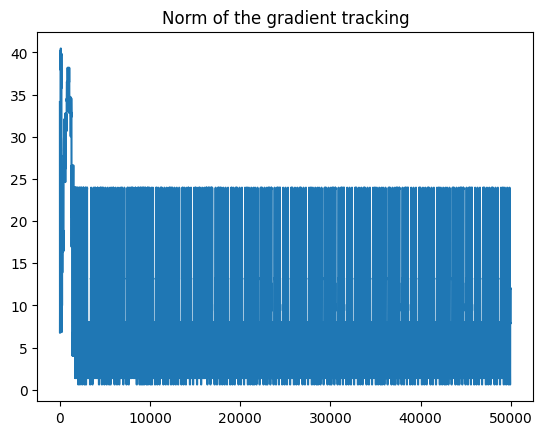

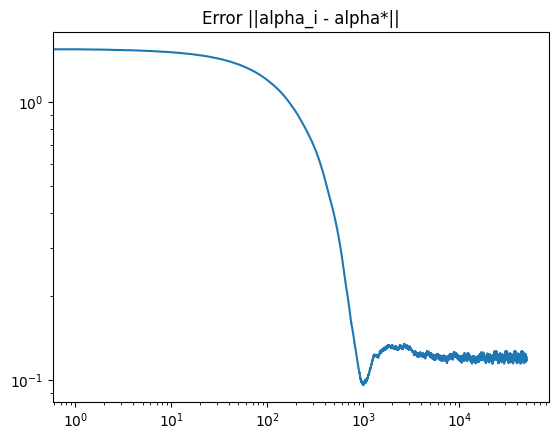

Result summary -----------------
Optimal centralised alpha =  [ 0.4882681   1.22218855  0.14747094  0.68231029 -0.33888689 -0.38294507
 -0.39323702 -0.29870643  0.04838297 -0.05026158]
Variance of the alpha =  2.196898174416079
True optimal alpha =  [ 0.46068431  1.16515481  0.13812705  0.61033592 -0.32202752 -0.35976473
 -0.3679263  -0.28591751  0.08221835 -0.00877834]


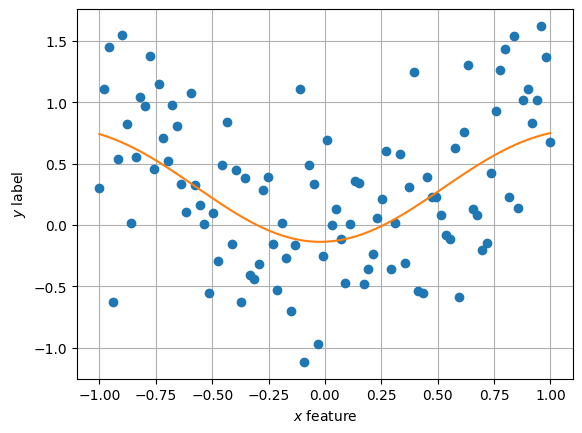

50000


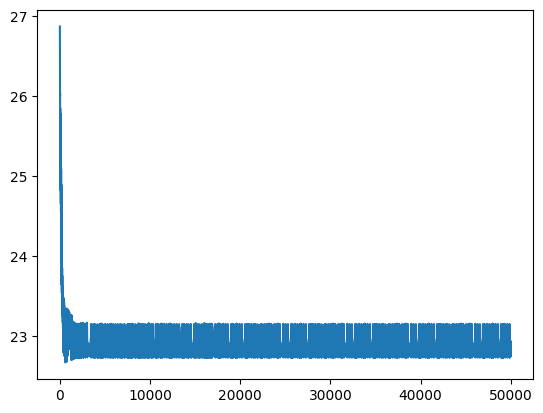

In [9]:
with open('first_database.pkl', 'rb') as f:
   x,y = pickle.load(f)

selection = True
num_points = 100
a = 5
index = -1
W = W_test
steps = [0.002 for _ in range(0,50000)]
print(steps)
alpha_star, ind = solve(x[:num_points],y[:num_points], selection=True)
alpha_list, F_list, ind, partition = solve_DGT(x[:num_points],y[:num_points], a, W, ind, steps = steps, plot = True, alpha_star = alpha_star, DGD = False)
m = len(alpha_list[index])//a
alpha_0 = alpha_list[index, :m]
alpha_consensus = np.mean([alpha_list[-1, i*m:(i+1)*m] for i in range(a)], axis = 0)
dist_alpha = [np.linalg.norm(alpha_consensus - alpha) for alpha in alpha_list[index]]
var_alpha = np.mean(dist_alpha)
print('Result summary -----------------')
print('Optimal centralised alpha = ', alpha_consensus)
print('Variance of the alpha = ', var_alpha)
print('True optimal alpha = ', alpha_star)

plot_me(x[:num_points],y[:num_points], alpha_consensus, ind, selection=selection)

print(len(F_list))
plt.plot(F_list)

The gradient tracking converges but not as much as it should. We observe that it got a hard time around the end. That is probably because the function $||\cdot||_1$ is smooth everywhere else than around zero. Thus, until we are near the optimum (which should verify that $y \approx K_{mm}\alpha$), we would not have to care about such an issue. However, when we reach the optimum and we pass from $y \succeq  K_{mm}\alpha$ to $K_{mm}\alpha \succeq y$ and vice versa again and again. Then, the algorithm has to face a non-smooth function and does appears a little bit less stable. 

Let us now implement *DRS* algorithm :

-> Algorithm 1 [Sca19] p 8.

Before anything, we want to compute the lipschitz constant of our problem. Obviously, as we have a quadratic term we won't have a lipschitz constant on $\mathbb{R}^m$. But in the paper settings, they compute the lipschitz constant on a convex and bounded set. We will assume we are on a ball of radius $R$ centered on $0_d$ (this satisfy the settings of this algorithm). Then, let us compute the lipschitz constant :
$$L_g = \sigma^2\lambda_{max}(K_{mm})R+\sqrt{m}\lambda_{max}(K_{mm})+\nu R$$

Note than here, we have computed the lipschitz constant for the general function but we need to carefully choose the $K_{mm}$, to get the full lipschitz constant :

$$
L_g = \sum_{i=1}^{a} \left( \sigma^2 \lambda_{\max}(K_{mm}^{(i)}) R +  \sqrt{m} \lambda_{\max}(K_{mm}^{(i)}) \right) + a \nu R.
$$


In [56]:
def solve_DRS(x, y, a, W, ind, R, Lg, repartition = None, eps = 1e-3, K_max = 50000, max_steps = 50000, plot = False, alpha_star = None, seed = 42):
    """
    Distributed (general => Decentralized possible) Randomized Smoothing

    x : the feature vector
    y : the label vector
    a : the number of agents
    W : the weight matrix of the graph communication
    ind : the indices of the selected points
    R : the radius of the ball on which we project the variables (because we are solving the problem on a compact set)
    Lg : the Lipschitz constant of the global function
    """
    # you can either select the points among the ones you have:
    if len(ind)>0:
        x2 = [x[i] for i in ind]

    # or take them uniformly distributed
    else:
        x2 = np.linspace(-1, 1, 10)
        ind = []
    m = len(x2)
    N_steps = np.floor(20*R*Lg*m**(1./4)/eps).astype(int) + 1
    print('True number of steps : ', N_steps)
    N_steps = min(N_steps, max_steps)
    print('Number of steps : ', N_steps)
    K = np.floor(5*R*Lg*m**(-1./4)/eps).astype(int) + 1
    print('True K : ', K)
    K = min(K, K_max)
    print('K : ', K)
    estimated_reached_epsilon = 20*R*Lg*m**(1./4)/N_steps
    print('Estimated born on reached epsilon : ', estimated_reached_epsilon)
    step_function = lambda step : 2./(1+np.sqrt(1+4./(step**2)))
    steps = [1]
    for i in range(1, N_steps+1):
        steps.append(step_function(steps[-1]))
    gamma_steps = [R*m**(-1./4)*step for step in steps]
    eta_steps = [R*step/(2*Lg*(m**0.25 + np.sqrt((t+1)/K))) for t, step in enumerate(steps)]
    n = len(x)

    W = np.kron(W, np.eye(m))
    x_parts, y_parts, partition = agent_partition(a, x, y, repartition)
    n = len(x)
    alpha = np.zeros([N_steps+1, m])
    support = np.zeros([N_steps+1, m])
    intervariable_y = np.zeros([N_steps+1, m])
    intervariable_z = np.zeros([N_steps+1, m])
    # sampling from N(o, I)
    np.random.seed(seed)
    F_list = [0,1000]
    Error_list = []
    k = 0
    while k < N_steps :
        radom_variable = np.random.randn(m*K)
        F = 0
        intervariable_y[k] = alpha[k] * (1 - steps[k]) + steps[k] * intervariable_z[k]
        grad = np.zeros(m*a)
        for i in range(a):
            for _k_ in range(K):
                y_loc = intervariable_y[k] + gamma_steps[k]*radom_variable[_k_*m:(_k_+1)*m]
                grad[m*i:(i+1)*m] += grad_F_K(x_parts[i], y_parts[i], y_loc, x2) * (1. / K)
        support[k+1] = (W @ grad * (1./steps[k]))[:m] + support[k]
        intervariable_z[k+1] = -eta_steps[k+1] * support[k+1] * R / np.maximum(np.linalg.norm(eta_steps[k+1] * support[k+1]), R)
        alpha[k+1] = (1 - steps[k]) * alpha[k] + steps[k] * intervariable_z[k+1]
        
        for i in range(a):
            F += F_K(x_parts[i], y_parts[i], alpha[k+1], x2)
        F_list.append(F)
        k += 1
        if k % 100 == 0:
            print('Step : ', k)
    if plot:
        # plt.plot(np.linalg.norm(support, axis=1))
        # plt.title('Norm of the gradient tracking')
        # plt.show()
        if alpha_star is not None:
            alpha_consensus = alpha_star
        else:
            alpha_consensus = alpha[-1]
        for l in range(k):
            Error = 0
            Error += np.linalg.norm(alpha[l] - alpha_consensus)
            Error_list.append(Error)
        plt.plot(Error_list)
        plt.xscale('log')
        plt.yscale('log')
        plt.title('Error ||alpha_i - alpha*|| (estimated epsilon = {})'.format(np.round(estimated_reached_epsilon, 4)))
        plt.show()
    return alpha, F_list[2:], ind, partition

In [8]:
def compute_Lg(x, y, a, ind, R, sigma = 0.5, nu = 1.0):
    if len(ind)>0:
        x2 = [x[i] for i in ind]

    # or take them uniformly distributed
    else:
        x2 = np.linspace(-1, 1, 10)
        ind = []
    m = len(x2)
    Lg = 0
    for i in range(a):
        Kmm = Cov(x2)
        lambda_max = np.max(np.linalg.eigvals(Kmm))
        print('Lambda max : ', lambda_max)
        Lgi = (sigma**2)*lambda_max*R + nu*R + np.sqrt(m)*lambda_max 
        Lg += Lgi
    return Lg

/tmp/ipykernel_1014/2470762034.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  x,y = pickle.load(f)


[np.float64(1.0000000000000047), np.float64(475.68096142703587)]
Min and max eigenvalues of A :  None
Lambda max :  7.646793304456612
Lambda max :  7.646793304456612
Lambda max :  7.646793304456612
Lambda max :  7.646793304456612
Lambda max :  7.646793304456612
True number of steps :  17560356
Number of steps :  5000
True K :  1388268
K :  30
Estimated born on reached epsilon :  3.512071100854139
(5, 20)
(5, 20)
Step :  100
Step :  200
Step :  300
Step :  400
Step :  500
Step :  600
Step :  700
Step :  800
Step :  900
Step :  1000
Step :  1100
Step :  1200
Step :  1300
Step :  1400
Step :  1500
Step :  1600
Step :  1700
Step :  1800
Step :  1900
Step :  2000
Step :  2100
Step :  2200
Step :  2300
Step :  2400
Step :  2500
Step :  2600
Step :  2700
Step :  2800
Step :  2900
Step :  3000
Step :  3100
Step :  3200
Step :  3300
Step :  3400
Step :  3500
Step :  3600
Step :  3700
Step :  3800
Step :  3900
Step :  4000
Step :  4100
Step :  4200
Step :  4300
Step :  4400
Step :  4500
Step :  

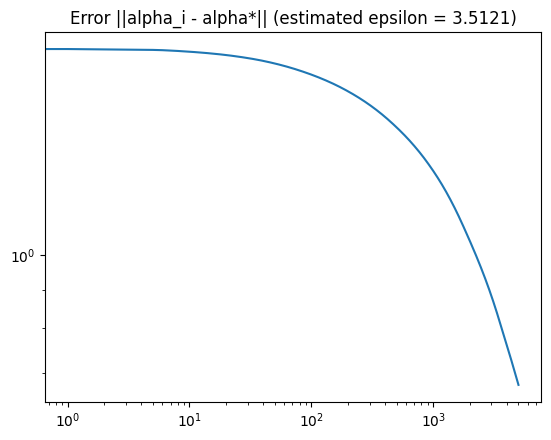

Result summary -----------------
Optimal centralised alpha =  [-0.4233479  -0.15620968 -0.05651916 -0.16834828  0.41874906  0.19997954
 -0.43054976  0.68428887 -0.08494189  0.63143703]
True optimal alpha =  [-0.62718782 -0.21397725 -0.09182669 -0.273273    0.54925618  0.27167126
 -0.6413935   1.23194559 -0.1129481   0.8047598 ]


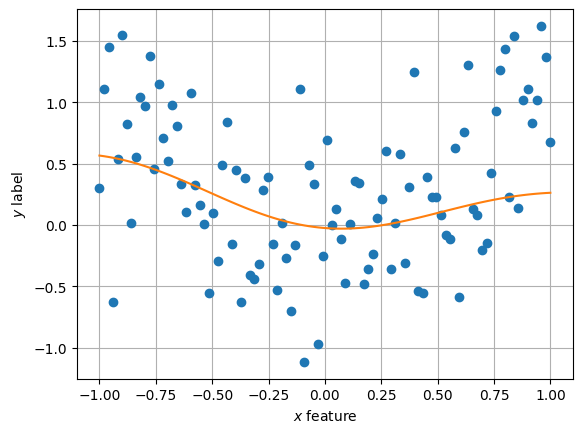

5000


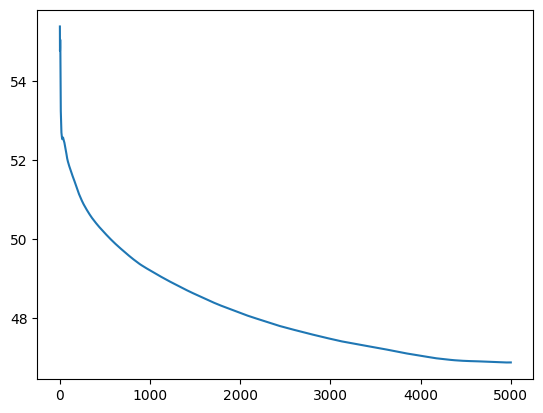

In [58]:
with open('first_database.pkl', 'rb') as f:
   x,y = pickle.load(f)

selection = True
num_points = 100
a = 5
index = -1
W = W_test
alpha_star, ind = solve(x[:num_points],y[:num_points], selection=True)

# define the radius of the ball
R = 3.0 # This radius is based on our knowledge of the solution so it is a bit cheating

### Computation of Lg 
Lg = compute_Lg(x[:num_points],y[:num_points], a, ind, R, 0.5, 1.0)

alpha_list, F_list, ind, partition = solve_DRS(x[:num_points],y[:num_points], a, W, ind, R, Lg, plot = True, K_max = 30, max_steps = 5000, alpha_star = alpha_star)
m = len(alpha_list[index])
alpha_0 = alpha_list[index]
alpha_consensus = alpha_list[index]
print('Result summary -----------------')
print('Optimal centralised alpha = ', alpha_consensus)
print('True optimal alpha = ', alpha_star)

plot_me(x[:num_points],y[:num_points], alpha_consensus, ind, selection=selection)

print(len(F_list))
plt.plot(F_list)

/tmp/ipykernel_1014/1161185147.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  x,y = pickle.load(f)


[np.float64(1.0000000000007032), np.float64(412.09041689299016)]
Min and max eigenvalues of A :  None
Lambda max :  6.861392359928484
Lambda max :  6.861392359928484
Lambda max :  6.861392359928484
Lambda max :  6.861392359928484
Lambda max :  6.861392359928484
True number of steps :  9648348
Number of steps :  40000
True K :  762769
K :  20
Estimated born on reached epsilon :  0.24120869961169328
(5, 20)
(5, 20)
Step :  100
Step :  200
Step :  300
Step :  400
Step :  500
Step :  600
Step :  700
Step :  800
Step :  900
Step :  1000
Step :  1100
Step :  1200
Step :  1300
Step :  1400
Step :  1500
Step :  1600
Step :  1700
Step :  1800
Step :  1900
Step :  2000
Step :  2100
Step :  2200
Step :  2300
Step :  2400
Step :  2500
Step :  2600
Step :  2700
Step :  2800
Step :  2900
Step :  3000
Step :  3100
Step :  3200
Step :  3300
Step :  3400
Step :  3500
Step :  3600
Step :  3700
Step :  3800
Step :  3900
Step :  4000
Step :  4100
Step :  4200
Step :  4300
Step :  4400
Step :  4500
Step : 

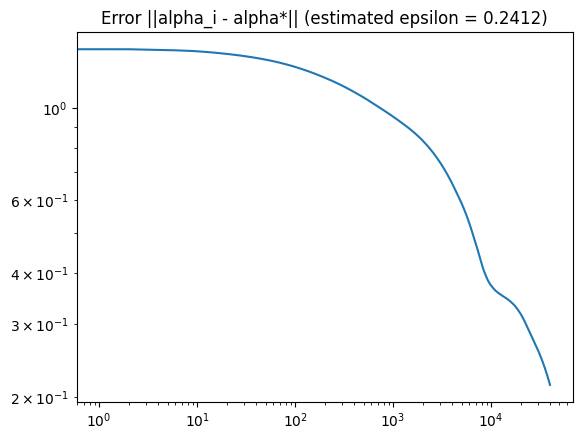

Result summary -----------------
Optimal centralised alpha =  [-0.36833531  0.40904742  0.36081306  0.06519806 -0.16178438 -0.25906016
  0.77993857  0.04152976 -0.2917921   0.4013811 ]
True optimal alpha =  [-0.4209574   0.47347438  0.41524225  0.0751767  -0.18365563 -0.29504756
  0.94727074  0.06539439 -0.3326512   0.4639824 ]


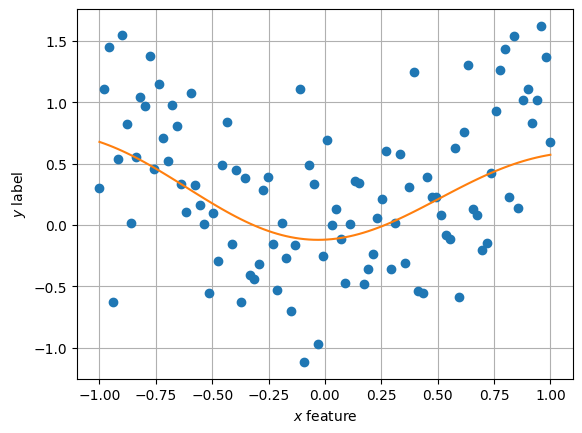

40000


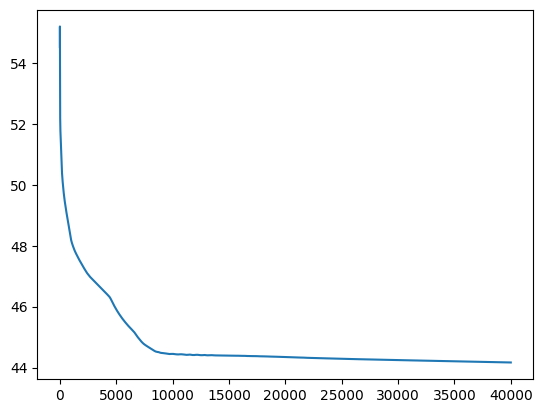

In [59]:
with open('first_database.pkl', 'rb') as f:
   x,y = pickle.load(f)

selection = True
num_points = 100
a = 5
index = -1
W = W_test
alpha_star, ind = solve(x[:num_points],y[:num_points], selection=True)

# define the radius of the ball
R = 2.0 # This radius is based on our knowledge of the solution so it is a bit cheating

### Computation of Lg 
Lg = compute_Lg(x[:num_points],y[:num_points], a, ind, R, 0.5, 1.0)

alpha_list, F_list, ind, partition = solve_DRS(x[:num_points],y[:num_points], a, W, ind, R, Lg, plot = True, K_max = 20, max_steps = 40000, alpha_star = alpha_star)
m = len(alpha_list[index])
alpha_0 = alpha_list[index]
alpha_consensus = alpha_list[index]
print('Result summary -----------------')
print('Optimal centralised alpha = ', alpha_consensus)
print('True optimal alpha = ', alpha_star)

plot_me(x[:num_points],y[:num_points], alpha_consensus, ind, selection=selection)

print(len(F_list))
plt.plot(F_list)

In [60]:
# achieved epsilon 
epsilon_attained = np.linalg.norm(alpha_list[-1] - alpha_star)
print('Epsilon attained : ', epsilon_attained)

Epsilon attained :  0.21427420820167087


It is trully impressive how tight their bound is. We almost reached the expected $\varepsilon = 0.24$, but the computation time is : 43 min 28 s. (CPU AMD Ryzen 7 5800H Laptop).
This shows the power of theory, we do know how to achieve a given $\varepsilon$ even if it could take quite some time.

### Strongly convex case

For the strongly convex case, we will need to compute $\beta_g$ which is the coefficient of strong convexity.

Before anything it is important to set the problem right. We are not in decentralized case so we should **not** write that we try to solve : 
$$ \min_{\theta\in\mathbb{R}^{a\times m}} \sum_{i=1}^a f_i(\theta_i)$$
Indeed, it is important in order to correctly compute the strong convexity coefficient to be clear on that. Thus we try to solve exactly :
$$ \min_{\theta\in\mathbb{R}^{m}} \sum_{i=1}^a f_i(\theta)$$

Let us derive $\beta_g$ from the objective function :

$$\beta_g = \sigma^2\,\sum_{i=1}^{a} \lambda_{\min}(K_{mm}^{(i)}) + a\,\nu$$
(otherwise, we would have had a min between each element)

Note that in comparison with the L2-norm, the L1-norm does not add a term to the strong convexity.

In [9]:
def Full_F_K(x_parts, y_parts, x2, alpha, sigma = 0.5, nu = 1.0):
    F = 0
    for i in range(len(x_parts)):
        F += F_K(x_parts[i], y_parts[i], alpha[i], x2, sigma, nu)
    return F

In [10]:
def compute_beta_g(x, y, a, ind, R, sigma = 0.5, nu = 1.0):
    if len(ind)>0:
        x2 = [x[i] for i in ind]

    # or take them uniformly distributed
    else:
        x2 = np.linspace(-1, 1, 10)
        ind = []
    m = len(x2)
    Lg = 0
    for i in range(a):
        Kmm = Cov(x2)
        lambda_min = np.min(np.linalg.eigvals(Kmm))
        print('Lambda min : ', lambda_min)
        Lgi = (sigma**2)*lambda_min + nu
        Lg += Lgi
    return Lg

In [11]:
def estimate_epsilon_for_str_case(N_t, Lg, beta_g, m):
    """
    Allow you to compute an estimation of the epsilon for strongly convex case.
    This estimation is based on parameters n_t, this is the most robust way to estimate epsilon based on the fact that we can restrict the number of iterations and K.
    """
    X_t = np.sum(N_t)
    T = len(N_t)
    two_power_sum = np.sum([2**i for i in range(1, T+1)])
    epsilon = ((two_power_sum * np.sqrt(2*np.sqrt(m)/beta_g) * Lg * np.log(8)) / X_t)**2
    return epsilon

In [12]:
def solve_DRS_str_cvx(x, y, a, W, ind, R, Lg, beta_g, repartition = None, eps = 1e-3, K_max = 50000, max_steps = 50000, N_t_max = 50000, plot = False, alpha_star = None, seed = 42):
    """
    Distributed (general => Decentralized possible) Randomized Smoothing for strongly convex case

    x : the feature vector
    y : the label vector
    a : the number of agents
    W : the weight matrix of the graph communication
    ind : the indices of the selected points
    R : the radius of the ball on which we project the variables (because we are solving the problem on a compact set)
    Lg : the Lipschitz constant of the global function
    beta_g : the strong convexity constant of the global function
    """
    # you can either select the points among the ones you have:
    if len(ind)>0:
        x2 = [x[i] for i in ind]

    # or take them uniformly distributed
    else:
        x2 = np.linspace(-1, 1, 10)
        ind = []
    m = len(x2)
    x_parts, y_parts, partition = agent_partition(a, x, y, repartition)
    F_0 = Full_F_K(x_parts, y_parts, x2, [np.zeros(m)]*a)
    F_star = Full_F_K(x_parts, y_parts, x2, [alpha_star]*a)
    c_eps_m = m**0.25 * np.log(8*(F_0 - F_star)/eps)
    N_steps = 2 * (np.floor(np.sqrt(2/(beta_g*eps))*Lg*c_eps_m).astype(int) + 1)
    print('True number of steps : ', N_steps)
    N_steps = min(N_steps, max_steps)
    print('Number of steps : ', N_steps)
    K = np.floor(70*Lg*c_eps_m**(-1)/np.sqrt(eps*beta_g)).astype(int) + 1
    print('True K : ', K)
    K = min(K, K_max)
    print('K : ', K)
    gamma = eps/(2*Lg*np.sqrt(m))
    n_0, n_1 = -1, np.floor(np.sqrt(Lg/(beta_g*gamma))*np.log(4*(F_0 - F_star)/eps)).astype(int) + 1
    n_1 = min(n_1, N_t_max)
    N_t = [n_0, n_1]
    for t in range(2, N_steps+1):
        loc_n_t = 2**t * (np.floor(np.sqrt(Lg/(beta_g*gamma))*np.log(8)).astype(int) + 1)
        N_t.append(min(loc_n_t, N_t_max))
    print('N_t : ', N_t)
    estimated_reached_epsilon = estimate_epsilon_for_str_case(N_t, Lg, beta_g, m) # 4 * (2/beta_g)*(Lg*c_eps_m/N_steps)**2
    print('Estimated born on reached epsilon : ', estimated_reached_epsilon)
    eta_steps = [None, gamma/Lg]
    for t in range(2, N_steps+2):
        eta_steps.append((gamma/(Lg * 2**(2*t))))
    print('Eta steps : ', eta_steps)
    mu_steps = [None]
    for t in range(1, N_steps+1):
        mu_steps.append((1-np.sqrt(beta_g*eta_steps[t]))/(1+np.sqrt(beta_g*eta_steps[t])))
    n = len(x)

    W = np.kron(W, np.eye(m))
    n = len(x)
    alpha = np.zeros([N_steps+1, m])
    # sampling from N(o, I)
    np.random.seed(seed)
    F_list = [0,1000]
    Error_list = []
    k = 1
    while k < N_steps :
        F = 0
        if k == 1:
            alpha[k] = np.zeros(m)
        else :
            alpha[k] = intervariable_alpha[N_t[k-1]+1]
        intervariable_y = np.zeros([N_t[k]+1, m])
        intervariable_alpha = np.zeros([N_t[k]+2, m])
        intervariable_alpha[0] = alpha[k]
        for t in range(1, N_t[k]+1): # ATTENTION : t is the index m in the paper and k is the index t
            radom_variable = np.random.randn(m*K)
            intervariable_y[t] = intervariable_alpha[t] * (1 + mu_steps[k]) - mu_steps[k] * intervariable_alpha[t-1]
            grad = np.zeros(m*a)
            for i in range(a):
                for _k_ in range(K):
                    y_loc = intervariable_y[t] + gamma*radom_variable[_k_*m:(_k_+1)*m]
                    grad[m*i:(i+1)*m] += grad_F_K(x_parts[i], y_parts[i], y_loc, x2) * (1. / K)
            intervariable_alpha[t+1] = intervariable_y[t] - (W @ grad * (eta_steps[k]))[:m]
        
        for i in range(a):
            F += F_K(x_parts[i], y_parts[i], alpha[k+1], x2)
        F_list.append(F)
        k += 1
        if k % 1 == 0 and alpha_star is not None:
            curr_dist = np.linalg.norm(alpha[-1] - alpha_star)
            print('Step : ' + str(k) + ' - Current distance : ' + str(curr_dist))
        if k == N_steps:
            alpha[-1] = intervariable_alpha[-1]
    if plot:
        if alpha_star is not None:
            alpha_consensus = alpha_star
        else:
            alpha_consensus = alpha[-1]
        for l in range(k):
            Error = 0
            Error += np.linalg.norm(alpha[l] - alpha_consensus)
            Error_list.append(Error)
        plt.plot(Error_list)
        plt.xscale('log')
        plt.yscale('log')
        plt.title('Error ||alpha_i - alpha*|| (estimated epsilon = {})'.format(np.round(estimated_reached_epsilon, 4)))
        plt.show()
    return alpha, F_list[2:], ind, partition

In [13]:
W_test = np.array([
    [1/3, 1/3, 1/3, 0,   0   ],
    [1/3, 1/3, 0,   1/3, 0   ],
    [1/3, 0,   1/3, 0,   1/3 ],
    [0,   1/3, 0,   1/3, 1/3 ],
    [0,   0,   1/3, 1/3, 1/3 ]
], dtype=float)

/tmp/ipykernel_969/1665878614.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  x,y = pickle.load(f)


[np.float64(1.0000000000007032), np.float64(412.09041689299016)]
Min and max eigenvalues of A :  None
Lambda max :  6.861392359928484
Lambda max :  6.861392359928484
Lambda max :  6.861392359928484
Lambda max :  6.861392359928484
Lambda max :  6.861392359928484
Lambda min :  2.7826395532694335e-12
Lambda min :  2.7826395532694335e-12
Lambda min :  2.7826395532694335e-12
Lambda min :  2.7826395532694335e-12
Lambda min :  2.7826395532694335e-12
(5, 20)
(5, 20)
True number of steps :  110374
Number of steps :  2
True K :  6601
K :  30
N_t :  [-1, 50000, np.int64(40128)]
Estimated born on reached epsilon :  0.0024282063944014586
Eta steps :  [None, np.float64(8.593776795771961e-09), np.float64(5.371110497357476e-10), np.float64(1.342777624339369e-10)]


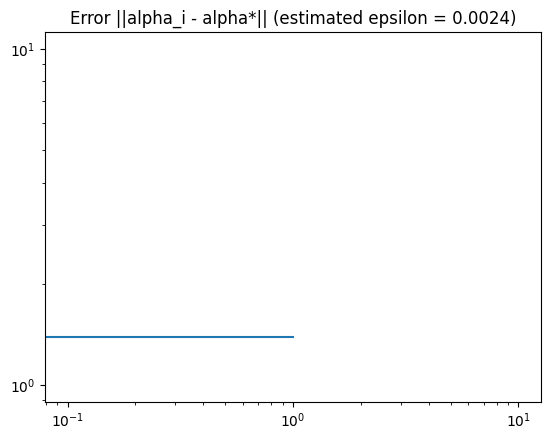

Result summary -----------------
Optimal centralised alpha =  [-0.30470995  0.38867176  0.33001714  0.03485683 -0.16143211 -0.23696861
  0.66778485  0.11252883 -0.26040945  0.37864237]
True optimal alpha =  [-0.4209574   0.47347438  0.41524225  0.0751767  -0.18365563 -0.29504756
  0.94727074  0.06539439 -0.3326512   0.4639824 ]


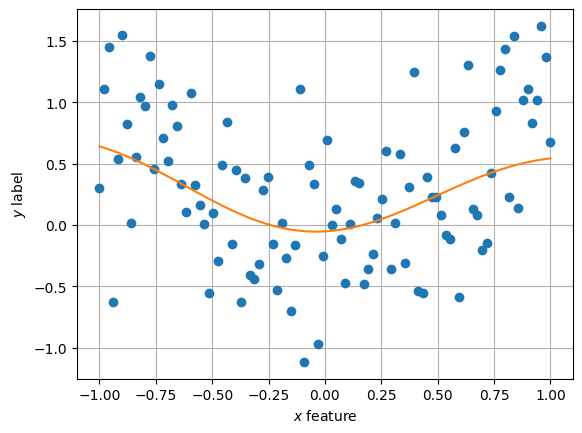

1


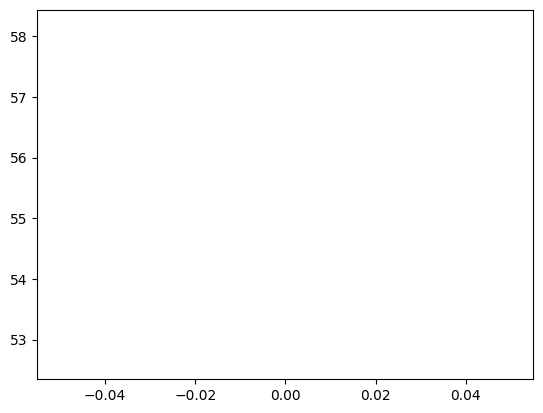

In [19]:
with open('first_database.pkl', 'rb') as f:
   x,y = pickle.load(f)

selection = True
num_points = 100
a = 5
index = -1
W = W_test
alpha_star, ind = solve(x[:num_points],y[:num_points], selection=True)

# define the radius of the ball
R = 2.0 # This radius is based on our knowledge of the solution so it is a bit cheating

### Computation of Lg and beta_g
Lg = compute_Lg(x[:num_points],y[:num_points], a, ind, R, 0.5, 1.0)
beta_g = compute_beta_g(x[:num_points],y[:num_points], a, ind, R, 0.5, 1.0)

alpha_list, F_list, ind, partition = solve_DRS_str_cvx(x[:num_points],y[:num_points], a, W, ind, R, Lg, beta_g, plot = True, K_max = 30, max_steps = 2, alpha_star = alpha_star, N_t_max = 50000) # np.inf
m = len(alpha_list[index])
alpha_0 = alpha_list[index]
alpha_consensus = alpha_list[index]
print('Result summary -----------------')
print('Optimal centralised alpha = ', alpha_consensus)
print('True optimal alpha = ', alpha_star)

plot_me(x[:num_points],y[:num_points], alpha_consensus, ind, selection=selection)

print(len(F_list))
plt.plot(F_list)

The graph plotted above do not give us much information. That is mainly because we compute only $T$ true $\alpha$ ($T=2$ here) with this algorithm and those settings. Indeed, the rest of the computation is intermediate variables which are meant to make us nearer to the optimal solution. Thus, we will just compare the final epsilon obtained :

In [21]:
print(np.linalg.norm(alpha_list[-1] - alpha_star))

0.3553826440577058


This algorithm is in theory, better than the one we used before, but in practice worst. And that is because the computation time of this algorithm needs to be fully taken into account in order to compute a proper optimal solution (it does not converges and explodes otherwise). To be clearer, you need to fullfil almost each $n_t$ steps to pass at the next $n_{t+1}$. This is mainly due to Nesterov acceleration which allow far better theoretical convergence but result in unstable algorithm. Indeed, for example, if you try computing the solution using this algorithm with Nesterov acceleration step $y^t_m = (1-\mu_t)x^t_m - \mu_t x_{m-1}^t$ but with a lower value for $n_t$ than the one theoretically required, then the momentum will be too big and your function will explode (you can verify that this step is the one responsible for the exploding values just by changing it to $y^t_m = x^t_m$).

Thus, we take here 76 min 13 sec time to obtain an error of $0.355$ which is worst than our DRS convex case algorithm. And further more, the bound on epsilon is bigger because harder to obtain practically speaking (refer to function `estimate_epsilon_for_str_case`).

In any case, our process is not really fair because we tested the algorithm with restrained parameters and it could be possible that with some hyperparameters tuning, one could get far better results but as explained before, Nesterov acceleration randered this process more unstable thus harder to tune.

/tmp/ipykernel_979/4118544770.py:11: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  x,y = pickle.load(f)


[np.float64(1.0000000000185902), np.float64(439.8787941438155)]
Min and max eigenvalues of A :  None
Lambda max :  6.75483506683554
Lambda max :  6.75483506683554
Lambda max :  6.75483506683554
Lambda max :  6.75483506683554
Lambda max :  6.75483506683554
Lambda min :  7.442510688011977e-11
Lambda min :  7.442510688011977e-11
Lambda min :  7.442510688011977e-11
Lambda min :  7.442510688011977e-11
Lambda min :  7.442510688011977e-11
(5, 20)
(5, 20)
True number of steps :  108002
Number of steps :  30
True K :  6554
K :  30
N_t :  [-1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
Estimated born on reached epsilon :  2.005029236004949e+17
Eta steps :  [None, np.float64(8.84645979647407e-09), np.float64(5.529037372796293e-10), np.float64(1.3822593431990734e-10), np.float64(3.4556483579976834e-11), np.float64(8.639120894994208e-12), np.float64(2.159780223748552e-12), np.float64(5.3994505

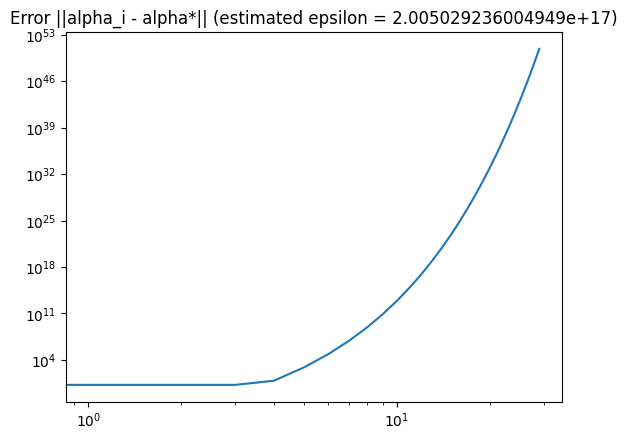

Result summary -----------------
Optimal centralised alpha =  [2.36910770e+52 2.48237155e+52 2.41577945e+52 1.93101135e+52
 2.38462355e+52 2.49627985e+52 2.50659156e+52 2.31212868e+52
 2.45265691e+52 2.24292372e+52]
True optimal alpha =  [ 0.79125584  0.1155309  -0.48327225  1.11388605 -0.30840736 -0.73969432
 -0.22691954  0.05964189  0.36221222  0.34571903]


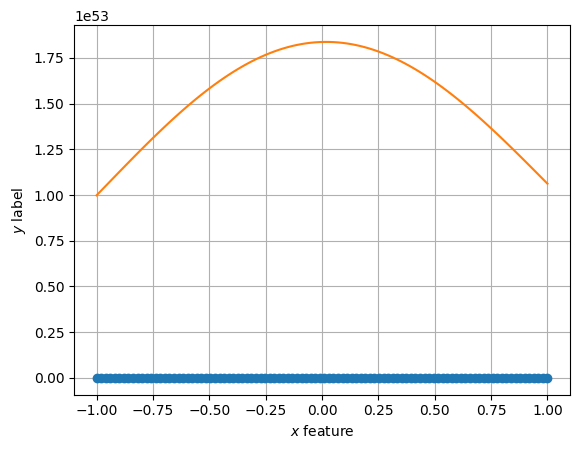

29


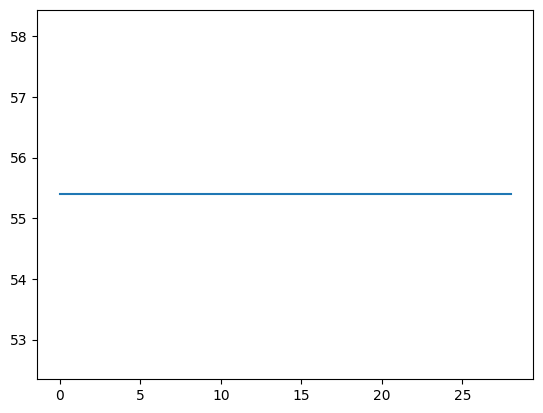

In [16]:
##########################################################################################################################################
######################################################## Exploding values test ###########################################################
##########################################################################################################################################

# We need to set N_t_max to a low values to pass less times in the loop made to learn intermediate variables.
# But doing so will results in an explosion of the values. This shows how unstable the algorithm is.

N_t_max = 100

with open('first_database.pkl', 'rb') as f:
   x,y = pickle.load(f)

selection = True
num_points = 100
a = 5
index = -1
W = W_test
alpha_star, ind = solve(x[:num_points],y[:num_points], selection=True)

# define the radius of the ball
R = 2.0 # This radius is based on our knowledge of the solution so it is a bit cheating

### Computation of Lg and beta_g
Lg = compute_Lg(x[:num_points],y[:num_points], a, ind, R, 0.5, 1.0)
beta_g = compute_beta_g(x[:num_points],y[:num_points], a, ind, R, 0.5, 1.0)

alpha_list, F_list, ind, partition = solve_DRS_str_cvx(x[:num_points],y[:num_points], a, W, ind, R, Lg, beta_g, plot = True, K_max = 30, max_steps = 30, alpha_star = alpha_star, N_t_max = N_t_max) # np.inf
m = len(alpha_list[index])
alpha_0 = alpha_list[index]
alpha_consensus = alpha_list[index]
print('Result summary -----------------')
print('Optimal centralised alpha = ', alpha_consensus)
print('True optimal alpha = ', alpha_star)

plot_me(x[:num_points],y[:num_points], alpha_consensus, ind, selection=selection)

print(len(F_list))
plt.plot(F_list)

We observe the expected unstabillity of the algorithm.

To finish this part, we believe that with an improved computation process, one could achieve better results. However, this wouldnt change much the comparison we made here.

## Multi-Step Primal-Dual Algorithm

Found : [Sca19] p 17.

### Graph Assumptions

Detailed here : [Sca19] p 13.

In their paper, the authors, introduce some assumptions on the graph that we will detail here : Let us note $\mathcal{G} = (\mathcal{V}, \mathcal{E}, W)$ our communication graph. We will do the following hypothesis on $\mathcal{G}$ :

- $W$ is symmetric and positive semi-definite.
- $Ker(W) = Span((1, 1,\cdots, 1)^T)$, the only vectors in the kernel of $W$ are constant vectors.
- For all $(i,j)\not \in \mathcal{E}$, $W_{ij} = 0$.

In [38]:
def assert_graph_assumptions(W, verbose = False):
    """
    This function allows you to check if the graph assumptions are verified.
    """
    n = W.shape[0]
    # Check if the matrix is symmetric
    assert np.allclose(W, W.T), 'The matrix is not symmetric'
    # Check if the matrix is positive semi-definite
    eig = np.linalg.eigvals(W)
    assert np.all(eig >= 0), 'The matrix is not positive semi-definite'
    # Check that the constant vector is in the Kernel
    assert np.allclose(W @ np.ones(n), np.zeros(n)), 'The constant vector is not in the Kernel'
    # Check that there is only one zero eigenvalue
    assert np.sum(eig < 1e-12) == 1, 'There is not only one zero eigenvalue'
    if verbose :
        print('Remember that the graph matrix represent the graph itself, so you need to make sure that non-negative weights are only on the edges of the graph.')
        print('The graph assumptions are verified.')

In [47]:
def compute_mixing_time(W):
    """
    This function allows you to compute the mixing time of a graph.
    """
    assert_graph_assumptions(W)
    n = W.shape[0]
    eig = np.linalg.eigvals(W)
    eig = np.sort(eig)
    delta = np.sqrt(eig[-1]/eig[2])
    return delta

In [48]:
W_test = np.array([
    [1/3, 1/3, 1/3, 0,   0   ],
    [1/3, 1/3, 0,   1/3, 0   ],
    [1/3, 0,   1/3, 0,   1/3 ],
    [0,   1/3, 0,   1/3, 1/3 ],
    [0,   0,   1/3, 1/3, 1/3 ]
], dtype=float)

W = np.eye(5) - W_test

assert_graph_assumptions(W, verbose = True)

delta = compute_mixing_time(W) # should always be bigger than 1 (this is obvious, but it is a requirement for the theory)
print('Mixing time of the graph : ', delta)

Remember that the graph matrix represent the graph itself, so you need to make sure that non-negative weights are only on the edges of the graph.
The graph assumptions are verified.
Mixing time of the graph :  1.6180339887498947


### The Algorithm

It is important to understand that now, we are in decentralized settings. This implies that the constants computation we have done before is useless and that is because the problem is now written in the following form :
$$ \min_{\theta\in\mathbb{R}^{a\times m}} \sum_{i=1}^a f_i(\theta_i)$$

Now, to properly introduce the Multi-Step Primal Dual Algorithm, we need to derive the dual problem associated to ours :
$$ \max_{\Lambda \in \mathbb{R}^{a\times m}}\min_{\Theta\in\mathbb{R}^{a\times m}} \sum_{i=1}^a f_i(\Theta_i) - tr(\Lambda^T \Theta (W^TW)^{\frac{1}{2}})$$

Where $(W^TW)^{\frac{1}{2}}$ is the square root of $W^TW$.

To get the proper optimal parameters, we will need to derives the value $L_l$ (we won't even need $\beta_l$ or $\zeta_l$ here). Recall that :
$$L_l = \sqrt{\frac{1}{n}\sum_i L_i^2}$$

Remember that we are trying to solve the non-smooth problem : 
$$\min_{\alpha \in \mathbb{R}^{m}} f_{NS}(\alpha) := \frac{\sigma^2}{2} \alpha^\top K_{mm} \alpha + \|y - K_{mm} \alpha\|_1 + \frac{\nu}{2} \|\alpha\|_2^2 $$

And that we computed for each agent objective function the Lipschitz constant $L_i$ as :
$$L_i = \sigma^2 \lambda_{\max}(K_{mm}^{(i)}) R +  \sqrt{m} \lambda_{\max}(K_{mm}^{(i)}) + \nu R.$$

Let us now prepare the ground for this algorithm :

In [49]:
def compute_Ll(x, y, a, ind, R, sigma = 0.5, nu = 1.0):
    if len(ind)>0:
        x2 = [x[i] for i in ind]

    # or take them uniformly distributed
    else:
        x2 = np.linspace(-1, 1, 10)
        ind = []
    m = len(x2)
    Ll = 0
    for i in range(a):
        Kmm = Cov(x2)
        lambda_max = np.max(np.linalg.eigvals(Kmm))
        print('Lambda min : ', lambda_max)
        Lli = (sigma**2)*lambda_max*R + nu*R + np.sqrt(m)*lambda_max 
        Ll += Lli**2
    return np.sqrt(Ll*(1./a))

In [68]:
def solve_MSPD(x, y, a, W, ind, R, Ll, delta, repartition = None, eps = 1e-3, max_steps = 50000, T_max = 50000, plot = False, alpha_star = None):
    """
    Multi-Step Primal-Dual

    x : the feature vector
    y : the label vector
    a : the number of agents
    W : the weight matrix of the graph communication
    ind : the indices of the selected points
    R : the radius of the ball on which we project the variables (because we are solving the problem on a compact set)
    Ll : the Lipschitz constant of each local function aggregated together.
    delta : the mixing time of the graph
    """
    # you can either select the points among the ones you have:
    if len(ind)>0:
        x2 = [x[i] for i in ind]

    # or take them uniformly distributed
    else:
        x2 = np.linspace(-1, 1, 10)
        ind = []
    m = len(x2)
    x_parts, y_parts, partition = agent_partition(a, x, y, repartition)
    N_steps = np.floor(2*R*Ll*delta/eps).astype(int) + 1
    print('True number of steps : ', N_steps)
    N_steps = min(N_steps, max_steps)
    print('Number of steps : ', N_steps)
    T_sub_step = np.floor(2*R*Ll/(eps*delta)).astype(int) + 1
    print('True number of sub-steps : ', T_sub_step)
    T_sub_step = min(T_sub_step, T_max)
    print('Number of sub-steps : ', T_sub_step)
    estimated_reached_epsilon = (delta + 1./delta) * 2*R*Ll / (N_steps + T_sub_step)
    print('Estimated born on reached epsilon : ', estimated_reached_epsilon)
    eta = a * R / (Ll * delta)
    lambda_1 = np.max(np.linalg.eigvals(W))
    gamma = 1./ (eta * lambda_1)
    n = len(x)

    W = np.kron(W, np.eye(m))
    alpha = np.zeros([N_steps+2, a*m])
    support_variable = np.zeros([N_steps+2, a*m])
    F_list = [0,1000]
    Error_list = []
    k = 1
    while k < N_steps :
        F = 0
        support_variable[k+1] = support_variable[k] - gamma * (2* W @ alpha[k] - W @ alpha[k-1])
        intervariable_alpha = np.zeros([T_sub_step+1, a*m])
        intervariable_alpha[0] = alpha[k]
        for t in range(T_sub_step):
            grad = np.zeros(m*a)
            for i in range(a):
                grad[m*i:(i+1)*m] = grad_F_K(x_parts[i], y_parts[i], intervariable_alpha[t, m*i:(i+1)*m], x2)
            intervariable_alpha[t+1] = t/(t+2) * intervariable_alpha[t] - 2./(t+2) * ((eta/a)*grad - eta * support_variable[k+1] - alpha[k])
        alpha[k+1] = intervariable_alpha[-1]
        for i in range(a):
            F += F_K(x_parts[i], y_parts[i], alpha[k+1][m*i:(i+1)*m], x2)
        F_list.append(F)
        k += 1
        if k % 50 == 0 and alpha_star is not None:
            curr_alpha = (1./k) * np.sum([alpha[i] for i in range(k)], axis = 0)
            mean_curr_alpha = np.mean([curr_alpha[m*i:(i+1)*m] for i in range(a)], axis = 0)
            curr_error = np.linalg.norm(mean_curr_alpha - alpha_star)
            print('Step : ' + str(k) + ' - Current distance : ' + str(curr_error))
    if alpha_star is not None:
        alpha_consensus = alpha_star
    else:
        alpha_consensus = alpha[-1]
    mean_alpha = []
    for l in range(1, k):
        Error = 0
        curr_alpha = (1./l) * np.sum([alpha[i] for i in range(l)], axis = 0)
        mean_curr_alpha = np.mean([curr_alpha[m*i:(i+1)*m] for i in range(a)], axis = 0)
        mean_alpha.append(mean_curr_alpha)
        Error += np.linalg.norm(mean_curr_alpha - alpha_consensus)
        Error_list.append(Error)
    if plot:
        plt.plot(Error_list)
        plt.xscale('log')
        plt.yscale('log')
        plt.title('Error ||alpha_i - alpha*|| (estimated epsilon = {})'.format(np.round(estimated_reached_epsilon, 4)))
        plt.show()
    return mean_alpha, F_list[2:], ind, partition

This algorithm is defined for the convex case but do recall that the results we obtained here are for a strongly-convex function. This is not the problem in the sense that strong-convexity implies convexity but it could still results in our algorithm overperforming compared to classical convex case or anything else.

In [63]:
W_test = np.array([
    [1/3, 1/3, 1/3, 0,   0   ],
    [1/3, 1/3, 0,   1/3, 0   ],
    [1/3, 0,   1/3, 0,   1/3 ],
    [0,   1/3, 0,   1/3, 1/3 ],
    [0,   0,   1/3, 1/3, 1/3 ]
], dtype=float)

W = np.eye(5) - W_test

assert_graph_assumptions(W, verbose = True)

delta = compute_mixing_time(W) # should always be bigger than 1 (this is obvious, but it is a requirement for the theory)
print('Mixing time of the graph : ', delta)

Remember that the graph matrix represent the graph itself, so you need to make sure that non-negative weights are only on the edges of the graph.
The graph assumptions are verified.
Mixing time of the graph :  1.6180339887498947


/tmp/ipykernel_979/2840232143.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  x,y = pickle.load(f)


[np.float64(1.000000000000512), np.float64(428.46809057028923)]
Min and max eigenvalues of A :  None
Lambda min :  6.96594074256993
Lambda min :  6.96594074256993
Lambda min :  6.96594074256993
Lambda min :  6.96594074256993
Lambda min :  6.96594074256993
(5, 20)
(5, 20)
True number of steps :  178057
Number of steps :  5000
True number of sub-steps :  68012
Number of sub-steps :  100
Estimated born on reached epsilon :  0.04824857555526193
Step : 50 - Current distance : 0.6568145975703561
Step : 100 - Current distance : 0.2419908377222442
Step : 150 - Current distance : 0.08907737673413138
Step : 200 - Current distance : 0.017374010150036225
Step : 250 - Current distance : 0.03983848931756099
Step : 300 - Current distance : 0.07015941638392745
Step : 350 - Current distance : 0.09244481474126795
Step : 400 - Current distance : 0.1095464712469208
Step : 450 - Current distance : 0.12289082325214505
Step : 500 - Current distance : 0.13370019213461673
Step : 550 - Current distance : 0.1423

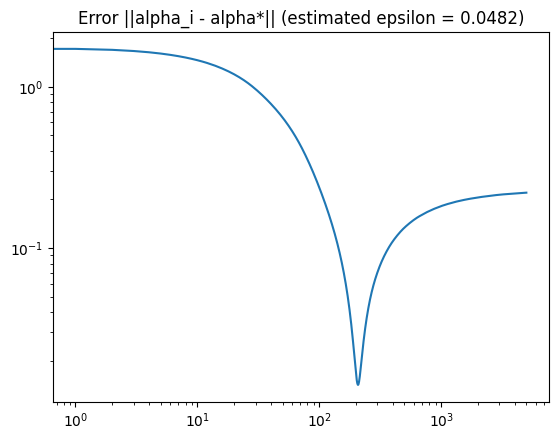

Result summary -----------------
Optimal centralised alpha =  [ 1.00395039 -0.68509774  0.29113712  0.58725584 -0.81007825  0.90981981
  0.21553268 -0.16084601  0.23913489 -0.46414682]
True optimal alpha =  [ 0.87766187 -0.60925466  0.26468758  0.52919815 -0.71634271  0.81294228
  0.2066799  -0.12167662  0.21803417 -0.41344507]


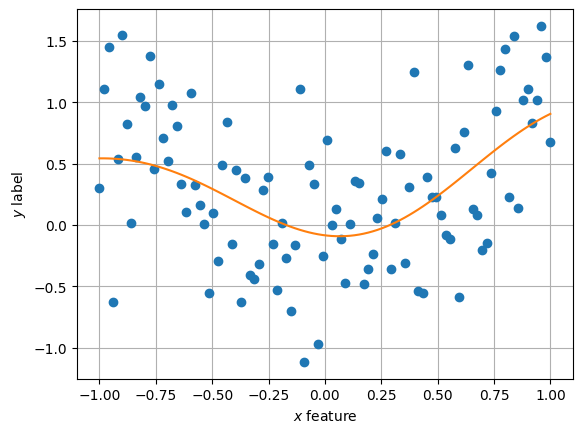

4999


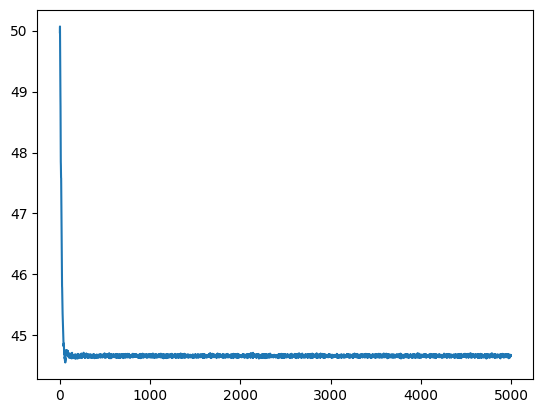

In [70]:
with open('first_database.pkl', 'rb') as f:
   x,y = pickle.load(f)

selection = True
num_points = 100
a = 5
index = -1
alpha_star, ind = solve(x[:num_points],y[:num_points], selection=True)

# define the radius of the ball
R = 2.0 # This radius is based on our knowledge of the solution so it is a bit cheating

### Computation of Ll
Ll = compute_Ll(x[:num_points],y[:num_points], a, ind, R, 0.5, 1.0)

alpha_list, F_list, ind, partition = solve_MSPD(x[:num_points],y[:num_points], a, W, ind, R, Ll, delta, plot = True, max_steps = 5000, alpha_star = alpha_star, T_max = 100) # np.inf
m = len(alpha_list[index])
alpha_consensus = alpha_list[index]
print('Result summary -----------------')
print('Optimal centralised alpha = ', alpha_consensus)
print('True optimal alpha = ', alpha_star)

plot_me(x[:num_points],y[:num_points], alpha_consensus, ind, selection=selection)

print(len(F_list))
plt.plot(F_list)

The algorithm has taken 24 min 39 sec to finish. Here we observe an interesting phenomenum. A bouncing curve of error. It is probably due to the fact that we proceeded with a restricted number of sub-iterations. This probably resulted in an introduced error which due to the way the optimum is computed (as a mean over all iteration and over all agents) propagated through the whole computation. But, if we only retain the best model computed so far, we see that we achieved an error of $0.039$ (at time $k=250$) which is almost the value we expected from the theory. This is once again a proof of how tight their bound are (recall that they have given lower and upper bound for this cases of similar magnitude).

**However**, it is possible that the "rebound" observed is due to the problem itself. Indeed, it is not clear wether the problem we introduced in order to solve this data fitting is good. And it could be highly dependant on the of points given, etc.

This is why we have made all those function general to use. So that it can be performed in other settings if one wants to.

## Conclusion

To conclude this notebook, we have seen that non-smooth problem can be solved with pretty accurate algorithm. But those algorithm require long computation time to achieve very low error $\varepsilon$. To be more specific on the dependance based on $\varepsilon$, we recommand you to take a look at Table 1 from their paper.

In any case, they achieve the best time possible for general cases like ours (non-smooth and other assumptions). But even if they are optimal in term of theory, it does not means that in practice, they perform the best. And this is mostly due to their high level of dependance on the hyperparameters of this problem.

Finally, theory has been confirmed with most of those experiments. But, it need to be compared with other regular issues that a computer scientist may face and that is not answered in their paper. it is highly probable than for general case, none of the above algorithm appears either usefull or easy to implement. And the fact that it is hard to have proper control on the running time make that even worse. Nonetheless, the results achieved in this paper are some impressive one in term of detail and tightness of bounds.

https://github.com/Raphael-Bernas/Distributed-Networks-Convex-Optimization.git